In [114]:
import pandas as pd
import numpy as np

#!pip install xgboost
from xgboost import XGBClassifier

#!pip install lightbm
from lightgbm import LGBMClassifier

#!pip install catboost
from catboost import CatBoostClassifier, Pool

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import time

%config InlineBackend.figure_format = 'retina' # для более четкой отрисовки графиков

In [6]:
ds = pd.read_csv('flight_delays.csv')
print('Размер датасета:{}'.format(ds.shape))

Размер датасета:(100000, 9)


In [7]:
ds.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_30min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [11]:
ds.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_30min    object
dtype: object

In [12]:
ds.isna().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
UniqueCarrier        0
Origin               0
Dest                 0
Distance             0
dep_delayed_30min    0
dtype: int64

In [15]:
ds.Month.value_counts()

c-8     8830
c-7     8706
c-3     8595
c-5     8543
c-6     8414
c-4     8408
c-10    8405
c-12    8265
c-11    8178
c-9     8163
c-1     8075
c-2     7418
Name: Month, dtype: int64

In [17]:
ds.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_30min'],
      dtype='object')

In [18]:
for col in ['Month', 'DayofMonth', 'DayOfWeek']:
    ds[col] = ds[col].apply(lambda x: x.split('-')[1]).astype(int) # выделим число и отбросим "с"

In [36]:
# сгенерим фичи согласно времени вылета
ds['part_of_day'] = 0
ds.loc[np.where(ds['DepTime'].apply(lambda x: (x>0) & (x < 600)))[0], 'part_of_day'] = 'night'
ds.loc[np.where(ds['DepTime'].apply(lambda x: (x>=600) & (x < 1200)))[0], 'part_of_day'] = 'morning'
ds.loc[np.where(ds['DepTime'].apply(lambda x: (x>=1200) & (x < 1800)))[0], 'part_of_day'] = 'day'
ds.loc[np.where(ds['DepTime'].apply(lambda x: (x>=1800) & (x < 2400)))[0], 'part_of_day'] = 'evening'

In [42]:
ds = ds.rename(columns={'dep_delayed_30min': 'target'})
ds.target = ds.target.map({'N':0, 'Y':1})

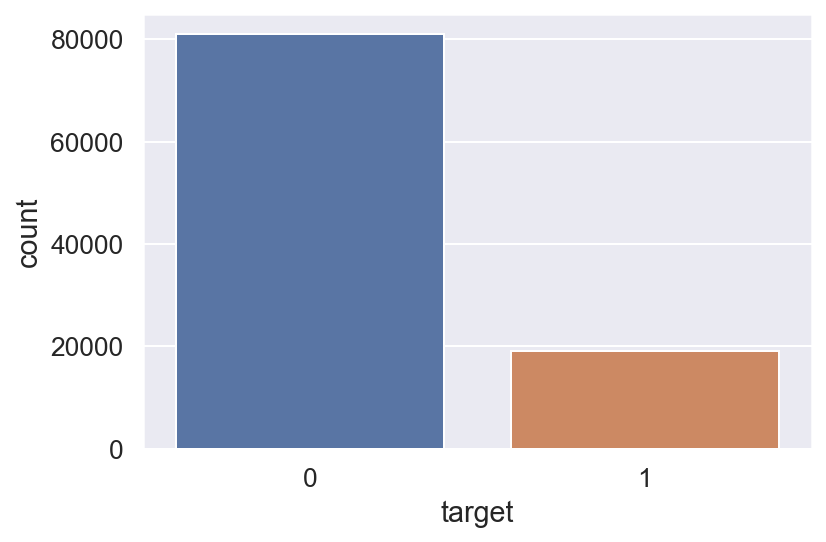

In [157]:
sns.countplot(x=ds.target);

In [53]:
num_cols = ds.drop(['target'], axis=1).select_dtypes(exclude='O').columns # числовые признаки
cat_cols = ds.select_dtypes(include='O').columns # категориальные признаки

<AxesSubplot:>

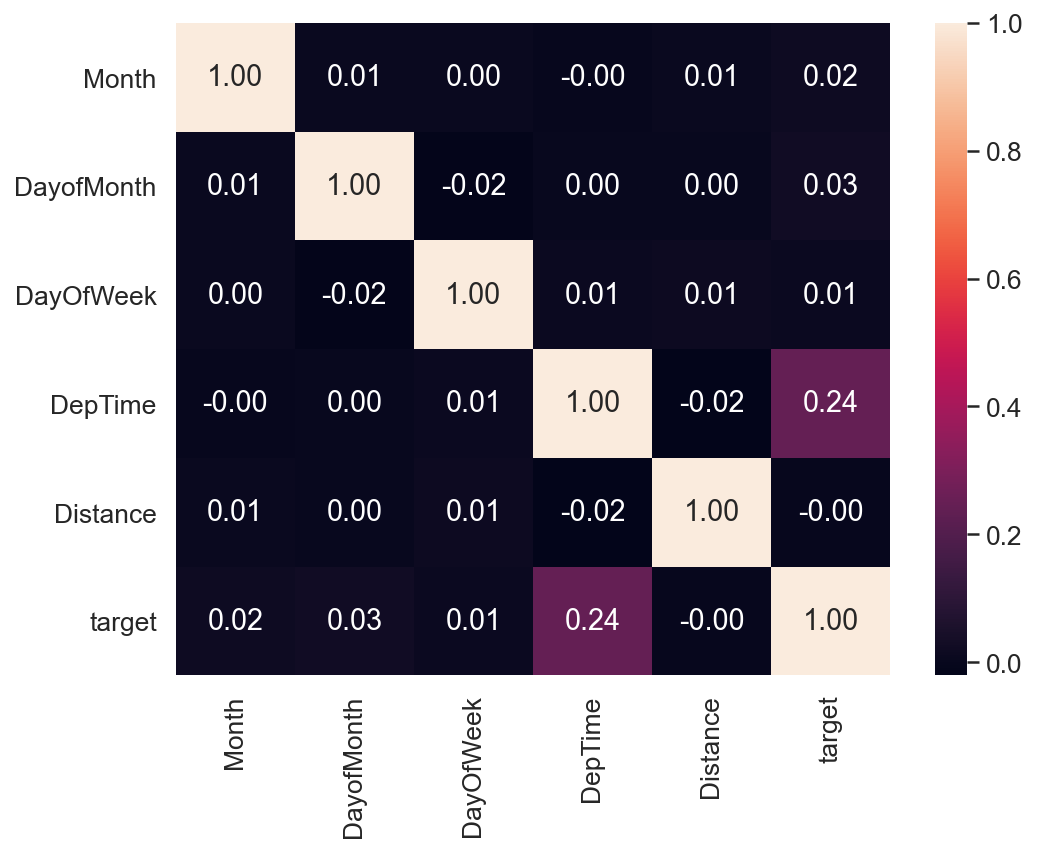

In [103]:
plt.figure(figsize=(8,6))
sns.heatmap(ds.corr(), annot=True, fmt='.2f')

### GradientBoosting, xgBoost, LGBM

In [54]:
ds_dummies = pd.get_dummies(ds)
print(ds_dummies.shape)

(100000, 611)


In [67]:
ds_dummies.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,target,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DH,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_HP,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_TZ,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,Origin_ABE,Origin_ABI,Origin_ABQ,Origin_ABY,Origin_ACK,Origin_ACT,Origin_ACV,Origin_ACY,Origin_ADK,Origin_ADQ,Origin_AEX,Origin_AGS,Origin_AKN,Origin_ALB,Origin_AMA,Origin_ANC,Origin_APF,Origin_ASE,Origin_ATL,...,Dest_SHV,Dest_SIT,Dest_SJC,Dest_SJT,Dest_SJU,Dest_SLC,Dest_SMF,Dest_SMX,Dest_SNA,Dest_SOP,Dest_SPI,Dest_SPS,Dest_SRQ,Dest_STL,Dest_STT,Dest_STX,Dest_SUN,Dest_SWF,Dest_SYR,Dest_TEX,Dest_TLH,Dest_TOL,Dest_TPA,Dest_TRI,Dest_TTN,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM,part_of_day_0,part_of_day_day,part_of_day_evening,part_of_day_morning,part_of_day_night
0,8,21,7,1934,732,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,4,20,3,1548,834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,9,2,5,1422,416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,11,25,6,1015,872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,10,7,6,1828,423,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [159]:
x_train, x_test, y_train, y_test = train_test_split(ds_dummies.drop(['target'], axis=1), 
                                                    ds_dummies['target'],
                                                    test_size=0.3
                                                   ) # разделим на тренировочную и тестовую выборки

In [160]:
transformer = PowerTransformer(standardize=True)
x_train[num_cols] = transformer.fit_transform(x_train[num_cols]) # нормализуем и стандартизуем числовые переменные
x_test[num_cols] = transformer.transform(x_test[num_cols]) # нормализуем и стандартизуем числовые переменные

In [161]:
def get_cross_val_score(x, y, model, cv):
    """Функция для оценки модели на кросс-валидации"""
    start_time = time.time()
    cv_score = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1) # прогоняем модель на кросс-валидации
    print(model.__class__.__name__)
    print("Время тренировки: %.1f s " % (time.time() - start_time))
    print('ROC-AUC на кросс-валидации: %.3f+-%.3f'% (np.mean(cv_score), np.std(cv_score)))

In [162]:
skf = StratifiedKFold(n_splits=7) # схема для кросс-валидации

# стэк моделей
for model in [
    GradientBoostingClassifier(n_estimators=100, random_state=17),
    XGBClassifier(n_estimators=100, random_state=17, n_jobs=-1),
    LGBMClassifier(n_estimators=100, random_state=17, n_jobs=-1),
]:
    get_cross_val_score(x_train, y_train, model, skf) # получим результаты на кросс-валидации
    

GradientBoostingClassifier
Время тренировки: 68.4 s 
ROC-AUC на кросс-валидации: 0.725+-0.005
XGBClassifier
Время тренировки: 247.5 s 
ROC-AUC на кросс-валидации: 0.740+-0.006
LGBMClassifier
Время тренировки: 7.8 s 
ROC-AUC на кросс-валидации: 0.740+-0.006


### Catboost

In [92]:
train, test = train_test_split(ds, test_size=0.3) # разделим на тренировочную и тестовую выборки

In [93]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,target,part_of_day
42458,9,8,4,2056,DL,ATL,BDL,859,0,evening
96967,1,17,2,1725,CO,DEN,EWR,1605,0,day
27664,3,18,5,1140,B6,BOS,FLL,1237,0,morning
87118,3,14,1,1822,XE,GRR,EWR,605,0,evening
63882,4,12,2,1608,US,CLT,TPA,508,0,day


In [109]:
feature_cols = list(train.columns.drop('target')) # список признаков
cat_index = [4, 5, 6, 8] # индексы категориальных признаков

In [112]:
def create_pool(df, feature_cols, cat_features):
    data = df[feature_cols]
    label = df["target"]
    dataset = Pool(data=data, label=label, cat_features=cat_features) # создаем пулы для подачи в алгоритм
    return dataset

In [115]:
train_dataset = create_pool(train, feature_cols, cat_index) # формируем тренировочный сет
test_dataset = create_pool(test, feature_cols, cat_index) # формируем тестовый сет

In [148]:
model = CatBoostClassifier(
    max_ctr_complexity=1,
    eval_metric="AUC:hints=skip_train~false",
    max_bin=128,
    iterations=2000,
    learning_rate=0.1,
    bagging_temperature=0.3,
    task_type="CPU",
    l2_leaf_reg=1000,
)
model = model.fit(
    train_dataset,
    eval_set=test_dataset,
    verbose=100,
    early_stopping_rounds=200,
)

0:	learn: 0.6654819	test: 0.6679816	best: 0.6679816 (0)	total: 33.6ms	remaining: 1m 7s
100:	learn: 0.7227236	test: 0.7218262	best: 0.7218262 (100)	total: 2.02s	remaining: 38s
200:	learn: 0.7324297	test: 0.7284057	best: 0.7284057 (199)	total: 4.13s	remaining: 37s
300:	learn: 0.7380499	test: 0.7316108	best: 0.7316108 (300)	total: 6.38s	remaining: 36s
400:	learn: 0.7408969	test: 0.7330752	best: 0.7330767 (398)	total: 8.76s	remaining: 34.9s
500:	learn: 0.7449809	test: 0.7350700	best: 0.7350873 (493)	total: 11.3s	remaining: 33.8s
600:	learn: 0.7478558	test: 0.7362911	best: 0.7362911 (600)	total: 13.4s	remaining: 31.1s
700:	learn: 0.7505982	test: 0.7375685	best: 0.7375685 (700)	total: 15.3s	remaining: 28.3s
800:	learn: 0.7526464	test: 0.7380899	best: 0.7380899 (800)	total: 17.1s	remaining: 25.6s
900:	learn: 0.7550871	test: 0.7389876	best: 0.7390067 (888)	total: 19s	remaining: 23.2s
1000:	learn: 0.7574065	test: 0.7396257	best: 0.7396304 (996)	total: 20.7s	remaining: 20.7s
1100:	learn: 0.75916

In [153]:
model.get_best_score() # лучшие показатели метрики

{'learn': {'Logloss': 0.404750893235805, 'AUC': 0.774518993505385},
 'validation': {'Logloss': 0.42528830670308404, 'AUC': 0.7430340148218197}}

In [154]:
pd.DataFrame(model.get_feature_importance(), 
             index=feature_cols, 
             columns=['Feature importance']).sort_values(['Feature importance'], ascending=False) # важность признаков

,Feature importance
DepTime,29.366749
part_of_day,12.643071
Month,11.740074
Origin,8.586060
DayofMonth,8.269943
UniqueCarrier,8.200514
Dest,7.912183
Distance,6.772880
DayOfWeek,6.508526
